In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def process_model_data(file_path, loss_key='eval_loss', trim_first_and_last=False):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    print(f"Keys in {file_path}:")
    print(list(data.keys()))
    
    log_history = data['log_history']
    
    epochs = []
    losses = []
    
    for entry in log_history:
        if loss_key in entry and 'epoch' in entry:
            epochs.append(entry['epoch'])
            losses.append(entry[loss_key])
    
    if not epochs:
        raise ValueError(f"No evaluation loss data found in {file_path}")
    
    if trim_first_and_last:
        return np.array(epochs[1:-1]), np.array(losses[1:-1])
        # return np.array(epochs[1:]), np.array(losses[1:])
    else:
        return np.array(epochs), np.array(losses)

In [4]:
hybrid_epochs, hybrid_losses = process_model_data("mamba_hybrid.json")
small_epochs, small_losses = process_model_data("mamba_small.json")
safe_small_epochs, safe_small_losses = process_model_data("safe_small.json", loss_key='loss', trim_first_and_last=True)

Keys in mamba_hybrid.json:
['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params']
Keys in mamba_small.json:
['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params']
Keys in safe_small.json:
['log_history']


In [5]:
len(hybrid_losses), len(small_losses), len(safe_small_losses)

(122, 122, 244)

In [6]:
def plot_data(x_data, y_data, labels, title, xlabel, ylabel, y_transform=None, use_log_scale=False):
    plt.figure(figsize=(12, 6))
    for x, y, label in zip(x_data, y_data, labels):
        y_plot = y_transform(y) if y_transform else y
        plt.plot(x, y_plot, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    if use_log_scale:
        plt.yscale('log')
        plt.ylim(bottom=1)  # Since perplexity is always >= 1
    plt.tight_layout()
    plt.show()

In [7]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

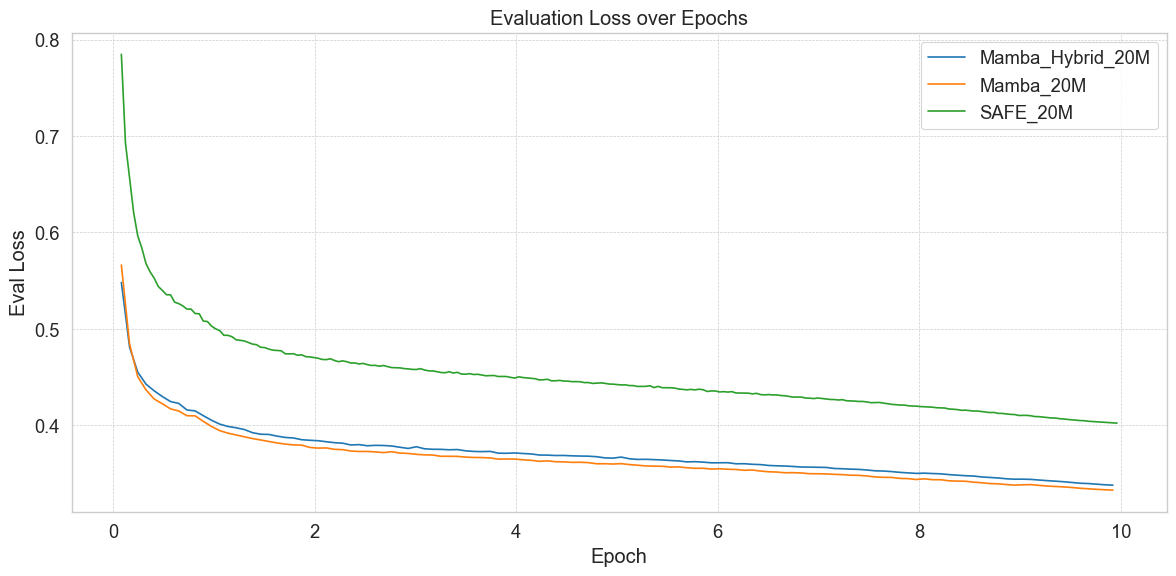

In [8]:
plot_data(
    [hybrid_epochs, small_epochs, safe_small_epochs],
    [hybrid_losses, small_losses, safe_small_losses],
    ['Mamba_Hybrid_20M', 'Mamba_20M', 'SAFE_20M'],
    'Evaluation Loss over Epochs',
    'Epoch',
    'Eval Loss'
)

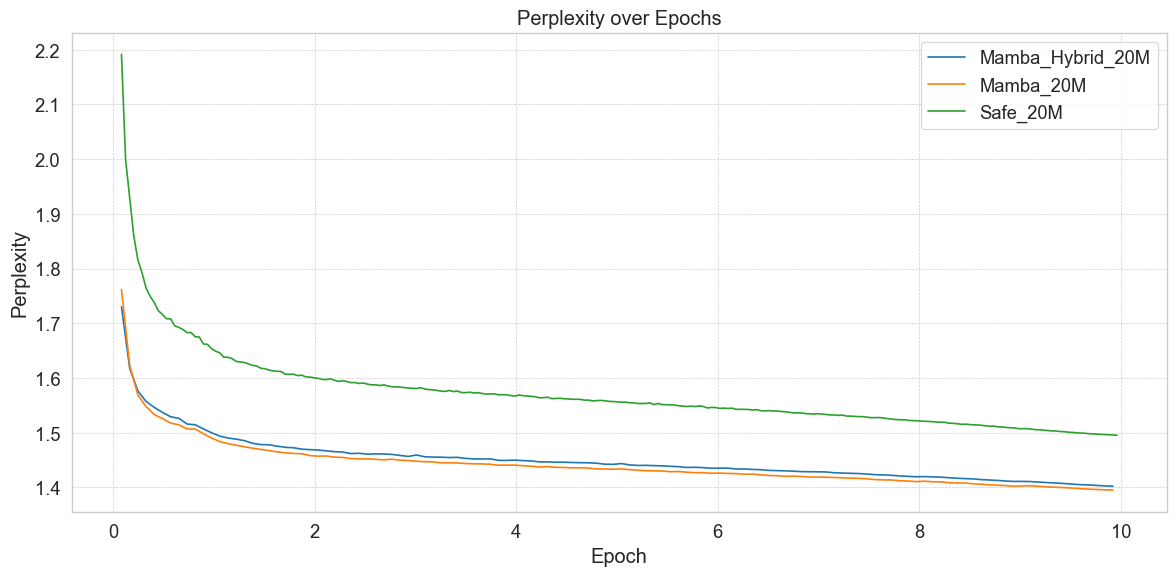

In [9]:
# Note: equal parameters as far as possible

plot_data(
    [hybrid_epochs, small_epochs, safe_small_epochs],
    [hybrid_losses, small_losses, safe_small_losses],
    ['Mamba_Hybrid_20M', 'Mamba_20M', 'Safe_20M'],
    'Perplexity over Epochs',
    'Epoch',
    'Perplexity',
    y_transform=np.exp
)

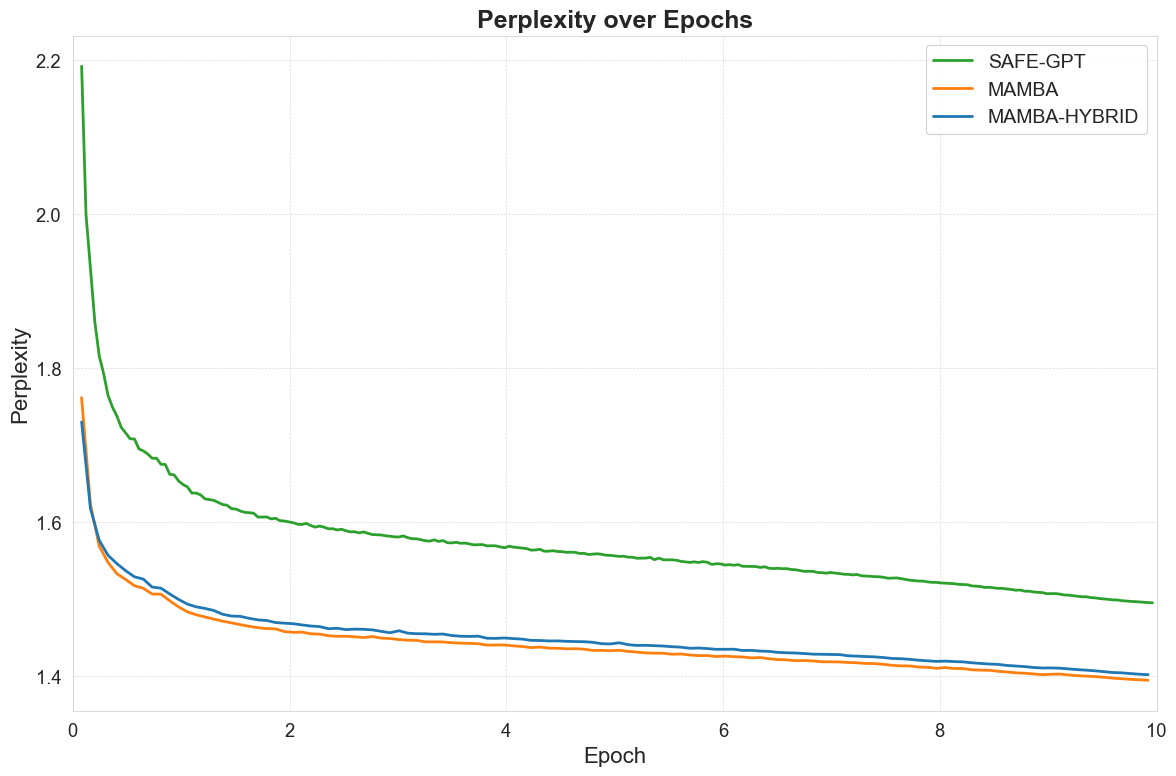

In [10]:
plt.figure(figsize=(12, 8))

# Plot each line with distinct colors
plt.plot(safe_small_epochs, np.exp(safe_small_losses), '-', color='#2ca02c', label='SAFE-GPT', linewidth=2.0)
plt.plot(small_epochs, np.exp(small_losses), '-', color='#ff7f0e', label='MAMBA', linewidth=2.0)
plt.plot(hybrid_epochs, np.exp(hybrid_losses), '-', color='#1f77b4', label='MAMBA-HYBRID', linewidth=2.0)

# Set the scale and limits
plt.xlim(0, 10)
# plt.ylim(1.3, 2.3)  # Adjust as needed to focus on the relevant range

# Add labels and title
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Perplexity', fontsize=16)
plt.title('Perplexity over Epochs', fontsize=18, fontweight='bold')

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend
plt.legend(fontsize=14, loc='upper right', frameon=True, framealpha=0.9)

# Customize ticks
plt.xticks(range(0, 11, 2))
plt.yticks(np.arange(1.4, 2.3, 0.2))

# Add annotations for key points
# plt.annotate('Rapid improvement', xy=(0.5, 2.5), xytext=(2, 2.7),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
#              fontsize=14, fontweight='bold')

# Enhance spines
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

# Adjust layout and save
plt.tight_layout()
plt.savefig('perplexity_over_epochs.png', dpi=300, bbox_inches='tight')
plt.show()